In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

In [2]:
# Model definition using VGG19 (general model, all layers trainable)
class VGG19NetGeneral(nn.Module):
    def __init__(self, out_features=2):
        super(VGG19NetGeneral, self).__init__()
        vgg19 = models.vgg19(pretrained=True)
        
        # Modify the classifier for the fall detection task
        in_features = vgg19.classifier[6].in_features
        vgg19.classifier[6] = nn.Linear(in_features, out_features)
        self.vgg19 = vgg19

    def forward(self, x):
        return self.vgg19(x)

In [3]:
# Initialize the VGG19 model
model = VGG19NetGeneral(out_features=2)

c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\merug/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100.0%


In [4]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


VGG19NetGeneral(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [5]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()


In [6]:
# Use Adam optimizer for faster convergence
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [7]:
# Implement mixed precision training
scaler = GradScaler()

C:\Users\merug\AppData\Local\Temp\ipykernel_7016\4126241097.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [8]:
# Data directory and transformations
data_dir = r'C:\Users\merug\Downloads\fall_detection\fall_detection_data'
batch_size = 16  # Reduced batch size

In [9]:
# Data transformations (reduce image size)
transform = transforms.Compose([
    transforms.Resize(112),  # Reduce image size to 112x112
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoaders
train_dataset = datasets.ImageFolder(f'{data_dir}/train', transform=transform)
val_dataset = datasets.ImageFolder(f'{data_dir}/val', transform=transform)
test_dataset = datasets.ImageFolder(f'{data_dir}/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [10]:
# Early Stopping Implementation
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def check_early_stopping(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=3)

In [11]:
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)


In [12]:

# Training function with mixed precision and early stopping
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    train_losses = []
    val_losses = []
    accuracies = []
    
    for epoch in range(epochs):
        model.train()
        training_loss = 0.0

        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            training_loss += loss.item() * inputs.size(0)

        training_loss /= len(train_loader.dataset)
        train_losses.append(training_loss)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        num_correct = 0
        num_examples = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)

                with autocast():
                    outputs = model(inputs)
                    loss = loss_fn(outputs, targets)

                valid_loss += loss.item() * inputs.size(0)
                correct = torch.eq(torch.max(outputs, dim=1)[1], targets).view(-1)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]

        valid_loss /= len(val_loader.dataset)
        val_losses.append(valid_loss)
        accuracy = num_correct / num_examples
        accuracies.append(accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {training_loss:.4f}, Val Loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}')

        # Adjust learning rate
        scheduler.step(valid_loss)

        # Early stopping
        if early_stopping.check_early_stopping(valid_loss):
            print("Early stopping triggered")
            break

    return train_losses, val_losses, accuracies


In [13]:
# Train the model
train_losses, val_losses, accuracies = train(model, optimizer, criterion, train_loader, val_loader, epochs=20, device=device)


C:\Users\merug\AppData\Local\Temp\ipykernel_7016\1490537169.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\merug\AppData\Local\Temp\ipykernel_7016\1490537169.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Train Loss: 0.3069, Val Loss: 0.2340, Accuracy: 0.8967
Epoch 2, Train Loss: 0.1920, Val Loss: 0.2344, Accuracy: 0.8612
Epoch 3, Train Loss: 0.1554, Val Loss: 0.2301, Accuracy: 0.9036
Epoch 4, Train Loss: 0.0983, Val Loss: 0.1348, Accuracy: 0.9537
Epoch 5, Train Loss: 0.0639, Val Loss: 0.1149, Accuracy: 0.9638
Epoch 6, Train Loss: 0.0734, Val Loss: 0.1235, Accuracy: 0.9668
Epoch 7, Train Loss: 0.0389, Val Loss: 0.1283, Accuracy: 0.9614
Epoch 8, Train Loss: 0.0642, Val Loss: 0.1168, Accuracy: 0.9530
Early stopping triggered


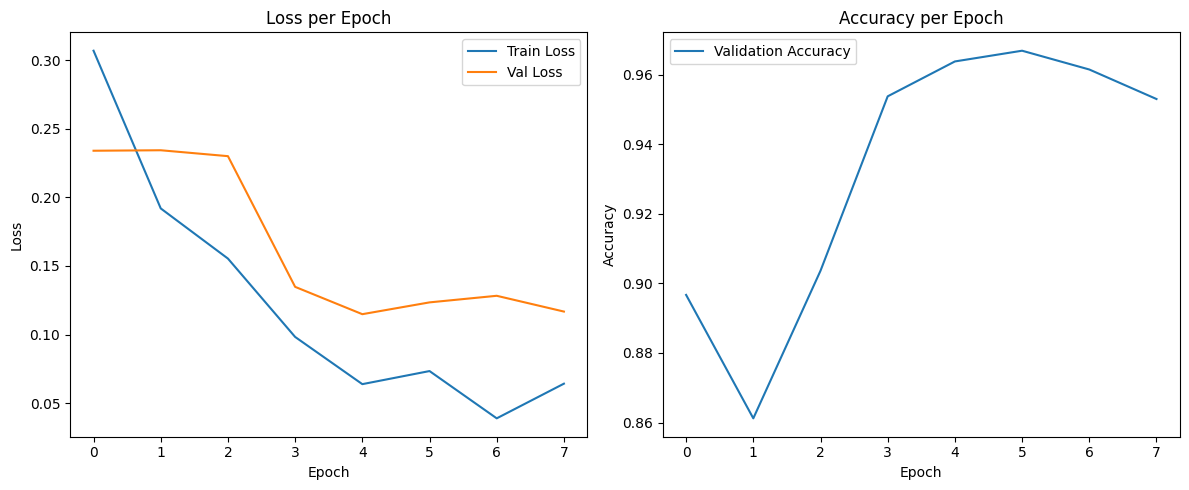

In [14]:
# Plotting Training & Validation Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Evaluate on test data
def test(model, test_loader, device):
    model.eval()
    num_correct = 0
    num_examples = 0
    outputs_np, targets_np = np.empty((0), dtype=int), np.empty((0), dtype=int)

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            with autocast():
                outputs = model(inputs)
            outputs = torch.max(outputs, dim=1)[1]

            correct = torch.eq(outputs, targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]

            outputs_np = np.concatenate([outputs_np, outputs.cpu().numpy()], axis=None)
            targets_np = np.concatenate([targets_np, targets.cpu().numpy()], axis=None)

    accuracy = num_correct / num_examples
    print(f'Accuracy on test data: {accuracy:.4f}')
    return outputs_np, targets_np

In [16]:
# Evaluate the model on the test set
outputs_np, targets_np = test(model, test_loader, device)


C:\Users\merug\AppData\Local\Temp\ipykernel_7016\2612479398.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Accuracy on test data: 0.9508


In [17]:

# Confusion Matrix
cf_matrix = confusion_matrix(targets_np, outputs_np)
print("Confusion Matrix:")
print(cf_matrix)


Confusion Matrix:
[[ 200   11]
 [  56 1096]]


In [18]:
# Save the model from the last fold
os.makedirs(f'train_model', exist_ok=True)
torch.save(model.state_dict(), 'train_model/vgg19.pt')

fine tuned model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

In [20]:
# Model definition using VGG19 (with fine-tuning)
class VGG19NetFineTune(nn.Module):
    def __init__(self, out_features=2):
        super(VGG19NetFineTune, self).__init__()
        vgg19 = models.vgg19(pretrained=True)
        
        # Fine-tuning: Freeze the earlier layers (features) but train the classifier layers
        for param in vgg19.features.parameters():
            param.requires_grad = False
        
        # Modify the classifier for the fall detection task
        in_features = vgg19.classifier[6].in_features
        vgg19.classifier[6] = nn.Linear(in_features, out_features)
        self.vgg19 = vgg19

    def forward(self, x):
        return self.vgg19(x)


In [21]:
# Initialize the fine-tuned VGG19 model
model = VGG19NetFineTune(out_features=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG19NetFineTune(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [22]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Fine-tuning only the classifier layers with Adam optimizer
optimizer = optim.Adam(model.vgg19.classifier.parameters(), lr=0.0001)


In [23]:
# Implement mixed precision training
scaler = GradScaler()

# Data directory and transformations
data_dir = r'C:\Users\merug\Downloads\fall_detection\fall_detection_data'
batch_size = 16  # Reduce batch size for larger models

C:\Users\merug\AppData\Local\Temp\ipykernel_7016\1107266884.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [24]:
# Data transformations (reduce image size for faster computation)
transform = transforms.Compose([
    transforms.Resize(112),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoaders
train_dataset = datasets.ImageFolder(f'{data_dir}/train', transform=transform)
val_dataset = datasets.ImageFolder(f'{data_dir}/val', transform=transform)
test_dataset = datasets.ImageFolder(f'{data_dir}/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [25]:
# Early Stopping Implementation
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def check_early_stopping(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=3)

In [26]:
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)


In [27]:

# Training function with mixed precision and early stopping
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    train_losses = []
    val_losses = []
    accuracies = []
    
    for epoch in range(epochs):
        model.train()
        training_loss = 0.0

        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            training_loss += loss.item() * inputs.size(0)

        training_loss /= len(train_loader.dataset)
        train_losses.append(training_loss)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        num_correct = 0
        num_examples = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)

                with autocast():
                    outputs = model(inputs)
                    loss = loss_fn(outputs, targets)

                valid_loss += loss.item() * inputs.size(0)
                correct = torch.eq(torch.max(outputs, dim=1)[1], targets).view(-1)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]

        valid_loss /= len(val_loader.dataset)
        val_losses.append(valid_loss)
        accuracy = num_correct / num_examples
        accuracies.append(accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {training_loss:.4f}, Val Loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}')

        # Adjust learning rate
        scheduler.step(valid_loss)

        # Early stopping
        if early_stopping.check_early_stopping(valid_loss):
            print("Early stopping triggered")
            break

    return train_losses, val_losses, accuracies


In [28]:

# Train the fine-tuned model
train_losses, val_losses, accuracies = train(model, optimizer, criterion, train_loader, val_loader, epochs=20, device=device)


C:\Users\merug\AppData\Local\Temp\ipykernel_7016\1490537169.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\merug\AppData\Local\Temp\ipykernel_7016\1490537169.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Train Loss: 0.2598, Val Loss: 0.1995, Accuracy: 0.9190
Epoch 2, Train Loss: 0.1829, Val Loss: 0.2022, Accuracy: 0.9113
Epoch 3, Train Loss: 0.1545, Val Loss: 0.1378, Accuracy: 0.9507
Epoch 4, Train Loss: 0.1342, Val Loss: 0.2051, Accuracy: 0.9298
Epoch 5, Train Loss: 0.1460, Val Loss: 0.1701, Accuracy: 0.9507
Epoch 6, Train Loss: 0.1130, Val Loss: 0.1287, Accuracy: 0.9576
Epoch 7, Train Loss: 0.0992, Val Loss: 0.1377, Accuracy: 0.9553
Epoch 8, Train Loss: 0.0755, Val Loss: 0.1725, Accuracy: 0.9445
Epoch 9, Train Loss: 0.0710, Val Loss: 0.2560, Accuracy: 0.9352
Early stopping triggered


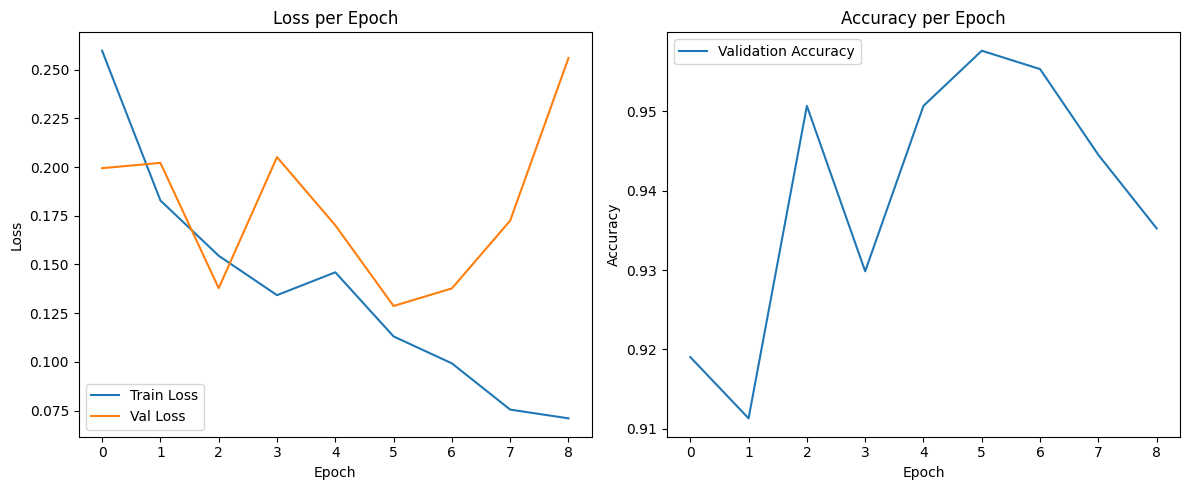

In [29]:

# Plotting Training & Validation Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
# Evaluate on test data
def test(model, test_loader, device):
    model.eval()
    num_correct = 0
    num_examples = 0
    outputs_np, targets_np = np.empty((0), dtype=int), np.empty((0), dtype=int)

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            with autocast():
                outputs = model(inputs)
            outputs = torch.max(outputs, dim=1)[1]

            correct = torch.eq(outputs, targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]

            outputs_np = np.concatenate([outputs_np, outputs.cpu().numpy()], axis=None)
            targets_np = np.concatenate([targets_np, targets.cpu().numpy()], axis=None)

    accuracy = num_correct / num_examples
    print(f'Accuracy on test data: {accuracy:.4f}')
    return outputs_np, targets_np


In [31]:
# Evaluate the model on the test set
outputs_np, targets_np = test(model, test_loader, device)


C:\Users\merug\AppData\Local\Temp\ipykernel_7016\106557386.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Accuracy on test data: 0.9347


In [32]:
# Confusion Matrix
cf_matrix = confusion_matrix(targets_np, outputs_np)
print("Confusion Matrix:")
print(cf_matrix)


Confusion Matrix:
[[ 131   80]
 [   9 1143]]


In [33]:
# Save the model from the last fold
os.makedirs(f'train_model', exist_ok=True)
torch.save(model.state_dict(), 'train_model/vgg19_finetuned.pt')

f1,precison,aug score

normal vgg16

In [34]:
# Initialize the model
model = VGG19NetGeneral(out_features=2)  # Make sure to initialize the model properly

# Load the saved model weights
model_path = 'train_model/vgg19.pt'
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()  # This disables layers like dropout and batchnorm from updating during inference


c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\merug\AppData\Local\Temp\ipykernel_7016\3021250609.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/p

VGG19NetGeneral(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [35]:
from sklearn.metrics import precision_score
precision = precision_score(targets_np, outputs_np)
print(f'Precision: {precision:.4f}')


Precision: 0.9346


In [36]:
from sklearn.metrics import recall_score
recall = recall_score(targets_np, outputs_np)
print(f'Recall: {recall:.4f}')


Recall: 0.9922


In [37]:
from sklearn.metrics import f1_score
f1 = f1_score(targets_np, outputs_np)
print(f'F1-Score: {f1:.4f}')


F1-Score: 0.9625


In [38]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(targets_np, outputs_np)
print(f'AUC: {auc:.4f}')


AUC: 0.8065


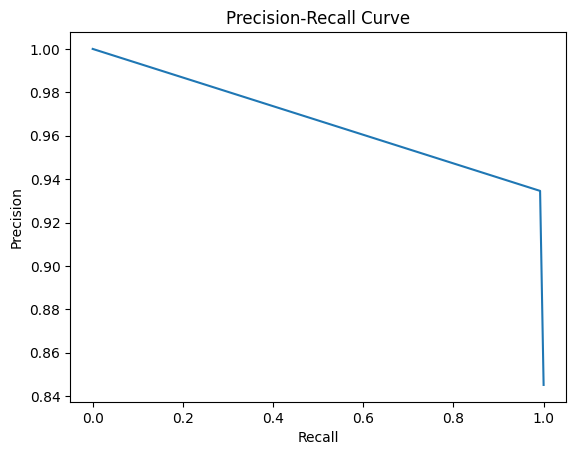

In [39]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(targets_np, outputs_np)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


In [40]:
# Initialize the model
model = VGG19NetFineTune(out_features=2)  # Make sure to initialize the model properly

# Load the saved model weights
model_path = 'train_model/vgg19_finetuned.pt'
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()  # This disables layers like dropout and batchnorm from updating during inference


c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\merug\AppData\Local\Temp\ipykernel_7016\2723625345.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/p

VGG19NetFineTune(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [41]:
from sklearn.metrics import precision_score
precision = precision_score(targets_np, outputs_np)
print(f'Precision: {precision:.4f}')


Precision: 0.9346


In [42]:
from sklearn.metrics import recall_score
recall = recall_score(targets_np, outputs_np)
print(f'Recall: {recall:.4f}')


Recall: 0.9922


In [43]:
from sklearn.metrics import f1_score
f1 = f1_score(targets_np, outputs_np)
print(f'F1-Score: {f1:.4f}')


F1-Score: 0.9625


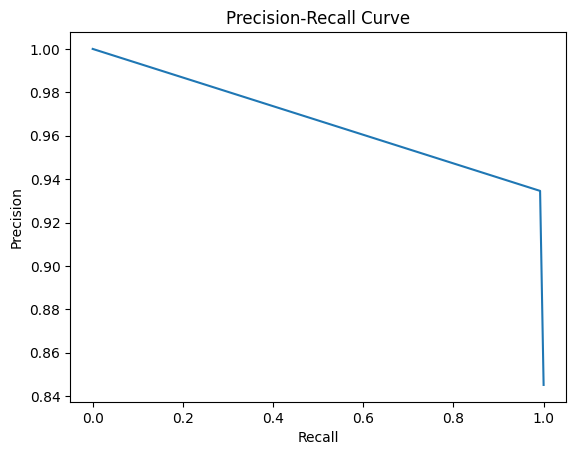

In [44]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(targets_np, outputs_np)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
